In [34]:
import csv
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import datetime
from random import randint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rashi/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['randint', 'std', 'f', 'indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [35]:
# Reading Data file
df_demog = pd.read_csv('data/DataTables/tblGEnrollment.csv', sep=',', header=None)
# data table actually exists a directory above the views.py file
df_demog.columns = df_demog.iloc[0]
# Use first row info as header
df_demog.drop(df_demog.index[0], inplace=True)
# Drop first row

df_demog['Weight'] = pd.to_numeric(df_demog['Weight'])
df_demog['Height'] = pd.to_numeric(df_demog['Height'])

df_demog = df_demog.replace({'M':0,'F':1})

df_demog = df_demog[['PtID','Gender','Weight','Height']]
df_demog.rename(index=str, columns={"VisitDt":"ReadingDt"}, inplace=True)
# renaming date column name for consistency
df_demog.tail()

,PtID,Gender,Weight,Height
52,53,0,61.9,178.2
53,54,0,70.7,191.2
54,55,0,46.7,151.2
55,56,1,66.2,164.0
56,57,1,71.0,165.0


In [36]:
# Reading saved csv file
df_cgms = pd.read_csv('data/DataTables/modified_cgms.csv', sep=',', header=None)
# data table actually exists a directory above the views.py file
df_cgms.columns = df_cgms.iloc[0]
# Use first row info as header
df_cgms.drop(df_cgms.index[0], inplace=True)
# Drop first row
df_cgms.drop(df_cgms.columns[[0]], axis=1, inplace=True)
# removing the first column of NaNs that shows up from reading csv. Don't ask why. Sigh.
df_cgms.drop(['MeterBG', 'Diff'], axis=1, inplace=True)
# dropping these to get rid of unnecessary NaNs

df_cgms['SensorGLU'] = pd.to_numeric(df_cgms['SensorGLU'])
df_cgms['ExBG'] = pd.to_numeric(df_cgms['ExBG'])
df_cgms['Episode'] = pd.to_numeric(df_cgms['Episode'])
df_cgms['ExStat'] = pd.to_numeric(df_cgms['ExStat'])
df_cgms['BeforeEx'] = pd.to_numeric(df_cgms['BeforeEx'])
df_cgms['AfterEx'] = pd.to_numeric(df_cgms['AfterEx'])


df_cgms['Diff'] = df_cgms['SensorGLU'] - df_cgms['ExBG']
df_cgms['Diff'] = df_cgms['Diff'].abs()

print(len(df_cgms[df_cgms['Episode'] == 1]))
print(len(df_cgms[df_cgms['ExStat'] == 1]))
df_cgms.tail()

86
515


,PtID,GVisitType,ReadingDt,ReadingTm,SensorGLU,ExBG,ExStat,BeforeEx,AfterEx,Episode,Diff
14955,52,Basal stopped,2000-01-18,18:15,117,NaN,0,0,0,0,NaN
14956,52,Basal stopped,2000-01-18,18:20,117,156.0,0,0,0,0,39.0
14957,52,Basal stopped,2000-01-18,18:25,119,NaN,0,0,0,0,NaN
14958,52,Basal stopped,2000-01-18,18:30,125,NaN,0,0,0,0,NaN
14959,52,Basal stopped,2000-01-18,18:35,134,191.0,0,0,0,0,57.0


In [37]:
df_count = df_cgms.groupby(['PtID', 'ReadingDt']).count()
df_sum = df_cgms.groupby(['PtID', 'ReadingDt']).sum()
df_mean = df_cgms.groupby(['PtID', 'ReadingDt']).mean()
df_std = df_cgms.groupby(['PtID', 'ReadingDt']).std()
#df_corr = df_cgms.groupby('PtID')['SensorGLU','ExBG'].corr()
df_count.tail()

0                GVisitType  ReadingTm  SensorGLU  ExBG  ExStat  BeforeEx  \
PtID ReadingDt                                                              
8    2000-01-31         136        136        136    22     136       136   
     2000-02-01         288        288        288    12     288       288   
     2000-02-02         188        188        188     6     188       188   
9    2000-02-18          84         84         84    14      84        84   
     2000-06-13          80         80         80    24      80        80   

0                AfterEx  Episode  Diff  
PtID ReadingDt                           
8    2000-01-31      136      136    22  
     2000-02-01      288      288    12  
     2000-02-02      188      188     6  
9    2000-02-18       84       84    14  
     2000-06-13       80       80    24

In [38]:
df_new = df_sum.reset_index()
# reset_index() changes grouped dataset rows into independent ones

df_new['Episode'] = df_sum.reset_index()['Episode'].gt(0).astype(int)
df_new['ExStat'] = df_sum.reset_index()['ExStat'].gt(0).astype(int)
# replace everything greater than 0 with 1 to make it binary

df_new['MeanSensor'] = df_mean.reset_index()['SensorGLU']
df_new['MeanManual'] = df_mean.reset_index()['ExBG']
df_new['StdSensor'] = df_std.reset_index()['SensorGLU']
df_new['StdManual'] = df_std.reset_index()['ExBG']
df_new['MeanDiff'] = df_mean.reset_index()['Diff']
df_new['StdDiff'] = df_std.reset_index()['Diff']

df_new.tail()

,PtID,ReadingDt,SensorGLU,ExBG,ExStat,BeforeEx,AfterEx,Episode,Diff,MeanSensor,MeanManual,StdSensor,StdManual,MeanDiff,StdDiff
132,8,2000-01-31,14073,2095.0,1,141,70,1,338.0,103.477941,95.227273,14.718075,23.002964,15.363636,9.906926
133,8,2000-02-01,34085,1815.0,0,0,0,1,124.0,118.350694,151.250000,53.510414,68.913813,10.333333,6.555128
134,8,2000-02-02,29224,360.0,0,0,0,0,23.0,155.446809,60.000000,85.285568,17.606817,3.833333,2.316607
135,9,2000-02-18,9311,1814.0,1,140,0,1,736.0,110.845238,129.571429,7.644975,54.065081,52.571429,17.990229
136,9,2000-06-13,8457,2244.0,1,134,74,1,581.0,105.712500,93.500000,30.096130,45.609877,24.208333,16.573890


In [39]:
# Printing out unique patients in datasets
patients_demog = np.sort(np.unique(df_demog['PtID'].astype(int)))
print(patients_demog, len(patients_demog))
patients_new = np.sort(np.unique(df_new['PtID'].astype(int)))
print(patients_new, len(patients_new))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 51
 52 53 54 55 56 57] 56
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 51 52
 53 54 55 56 57] 55


In [40]:
print(df_new.dtypes, '\n', df_demog.dtypes)

0
PtID           object
ReadingDt      object
SensorGLU       int64
ExBG          float64
ExStat          int64
BeforeEx        int64
AfterEx         int64
Episode         int64
Diff          float64
MeanSensor    float64
MeanManual    float64
StdSensor     float64
StdManual     float64
MeanDiff      float64
StdDiff       float64
dtype: object 
 0
PtID       object
Gender      int64
Weight    float64
Height    float64
dtype: object


In [41]:
df = pd.merge(df_demog, df_new, on='PtID')
df = df.drop(['PtID','ReadingDt','SensorGLU','ExBG','Diff'], axis=1)
# drop unnecessary columns
#df = df.drop(['Gender','Height','Weight'], axis=1)
# removing demographic info for now, as it made it completely deterministic!!
df.tail()

,Gender,Weight,Height,ExStat,BeforeEx,AfterEx,Episode,MeanSensor,MeanManual,StdSensor,StdManual,MeanDiff,StdDiff
132,0,46.7,151.2,1,189,205,0,176.080645,170.928571,22.258760,35.921847,23.571429,14.340445
133,1,66.2,164.0,1,144,62,1,93.949367,96.333333,27.296519,28.982753,22.388889,18.081967
134,1,66.2,164.0,1,149,128,1,104.068493,109.470588,16.905233,39.285999,27.647059,13.105062
135,1,71.0,165.0,1,137,69,1,166.223529,139.562500,66.815912,73.054289,22.125000,18.463929
136,1,71.0,165.0,1,141,105,0,164.185185,140.368421,40.336742,55.183744,33.368421,20.437467


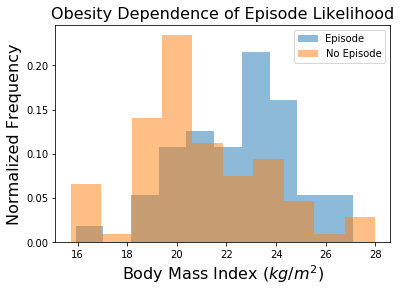

In [80]:
# Check trend of weight with episode

ex_yes = df[df['ExStat'] == 1]
ex_no = df[df['ExStat'] == 0]

hypo_yes = df[df['Episode'] == 1]
hypo_no = df[df['Episode'] == 0]

ex_yes_bef = ex_yes.iloc[:,4].values
ex_yes_aft = ex_yes.iloc[:,5].values
# Manual Meter Readings

df['BMI'] = df['Weight']/(df['Height']/100)**2
w_yes = hypo_yes.iloc[:,13].values
w_no = hypo_no.iloc[:,13].values
# Manual Meter Readings

kwargs = dict(histtype='stepfilled', alpha=0.5, normed=True, bins=10)

plt.hist(w_yes, **kwargs, label='Episode')
plt.hist(w_no, **kwargs, label='No Episode')

#plt.hist(ex_yes_bef, **kwargs, label='Exercise')
#plt.hist(ex_yes_aft, **kwargs, label='No Exercise')

title('Obesity Dependence of Episode Likelihood', fontsize=16)
ylabel("Normalized Frequency", fontsize=16)
xlabel(r"Body Mass Index $(kg/m^2)$", fontsize=16)
plt.legend()

In [51]:
df.head()

,Gender,Weight,Height,ExStat,BeforeEx,AfterEx,Episode,MeanSensor,MeanManual,StdSensor,StdManual,MeanDiff,StdDiff,BMI
0,0,42.7,147.0,1,144,145,0,154.253521,136.214286,29.817405,40.413590,20.214286,17.254558,19.760285
1,0,53.0,170.5,1,141,91,0,167.086957,142.052632,40.100876,47.235196,23.052632,14.237953,18.231697
2,0,53.0,170.5,1,145,85,0,140.317073,121.166667,31.269785,42.141568,31.333333,30.101788,18.231697
3,1,64.5,166.8,1,122,45,1,161.863014,113.851852,77.758391,46.091634,18.592593,13.995217,23.182893
4,1,64.5,166.8,0,0,0,0,352.308824,313.500000,42.387430,41.719300,61.000000,12.727922,23.182893


In [9]:
df = df.dropna(axis=0, how='any')
# drop NaN values

y = df['Episode']
y = y.as_matrix().astype(int)
print(len(y[y==1]), len(y[y==0]))

50 81


In [10]:
df.to_csv('data/DataTables/modified_final.csv', sep=',')
# Save modified dataframe to csv file

In [11]:
df.drop(['Episode','BMI'],axis=1,inplace=True)
# 'Episode' is target only, so drop it from features!
x = df.as_matrix()

features = df.columns
print(features)
print(shape(x))

Index(['Gender', 'Weight', 'Height', 'ExStat', 'BeforeEx', 'AfterEx',
       'MeanSensor', 'MeanManual', 'StdSensor', 'StdManual', 'MeanDiff',
       'StdDiff'],
      dtype='object', name=0)
(131, 12)


In [12]:
from sklearn.model_selection import train_test_split

######################### Building Training and Testing Datasets ##############################
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

np.savetxt('files/x_train.dat', x_train) ; np.savetxt('files/y_train.dat', y_train)
np.savetxt('files/x_test.dat', x_test) ; np.savetxt('files/y_test.dat', y_test)

print("train:",len(y_train[y_train==1]), len(y_train[y_train==0]))
print("test:",len(y_test[y_test==1]), len(y_test[y_test==0]))

train: 37 61
test: 13 20


#### best recall: 0.56671899529
#### best n_estimators: 50
#### best min_sample_leaf: 2
#### best warm_start: False
#### best max_depth 7
#### best max_features: 10

In [20]:
######################################### Training Forest ####################################################
def train_rf(x_train, y_train, trees_rf, samples_rf, warm_rf, depth_rf, features_rf):
  model = RandomForestClassifier(min_samples_leaf=samples_rf, oob_score=True, n_estimators=trees_rf, 
                                 warm_start = True, max_depth = depth_rf, max_features=features_rf)
  model.fit(x_train,y_train)
  return model

model = train_rf(x_train, y_train, 50, 2, False, 7, 10)
joblib.dump(model,'test_models/model.pkl') 

['test_models/model.pkl']

In [21]:
########################################### Testing ####################################################
def testing(x_test, model):
  y_pred = model.predict(x_test)
  prob = model.predict_proba(x_test) # To get confidence of the prediction
  return np.array(y_pred), np.array(prob)

y_pred, prob = testing(x_test, model)

In [71]:
def plot_confusion_matrix(cm, ylabel, xlabel):
  plt.figure()
  cmap = plt.cm.Oranges
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title('Normalized Confusion Matrix', fontsize=16)
  plt.colorbar()
  for (i, j), z in np.ndenumerate(cm):
    if(z<0.5):
        color = 'k'
    else:
        color = 'w' # har
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', color=color, fontsize=16)
# write cm values on grid
  tick_labels = ['normal', 'hypo']
  tick_marks = np.arange(len(tick_labels))
  plt.xticks(tick_marks, tick_labels, fontsize=13, rotation=45)
  plt.yticks(tick_marks, tick_labels, fontsize=13)
  plt.tight_layout()
  plt.ylabel(ylabel, fontsize=16)
  plt.xlabel(xlabel, fontsize=16)

def plot_hist(prob_meta, prob_prec):
  fig = plt.figure()
  ax1 = fig.add_subplot(211)
  ax2 = fig.add_subplot(212)

  results, edges = np.histogram(prob_meta, bins=np.linspace(0,1,21,endpoint=True) , normed=True)
  binWidth = edges[1] - edges[0]
  ax1.bar(edges[:-1], results*binWidth, binWidth, facecolor='b', label = 'Normal')  

  results, edges = np.histogram(prob_prec, bins=np.linspace(0,1,21,endpoint=True), normed=True)
  binWidth = edges[1] - edges[0]
  ax2.bar(edges[:-1], results*binWidth, binWidth, facecolor='r', label = 'Hypo')

  ax1.set_xlim(0,1)
  ax2.set_xlim(0,1)
  ax1.set_ylim(0,0.5)
  ax2.set_ylim(0,0.5)

  plt.suptitle('Predicted Hypoglycemic Episode Probabilities', fontsize=15)
  ax1.set_ylabel('Probability', fontsize=15)
  ax2.set_ylabel('Probability', fontsize=15)
  ax2.set_xlabel('Hypoglycemic Episode Prediction Probability', fontsize=15)
  ax1.legend(loc='best', fontsize=20)
  ax2.legend(loc='best', fontsize=20)
  #plt.tight_layout()

correct predictions (0 in 0 & 1 in 1): 78.79
mean probabilities = for 0: 0.61 & for 1: 0.39
Confusion Matrix true_pred:
 [[18  2]
 [ 5  8]]
oob_score 0.68
recall_score 0.62


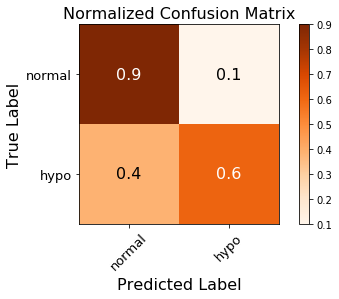

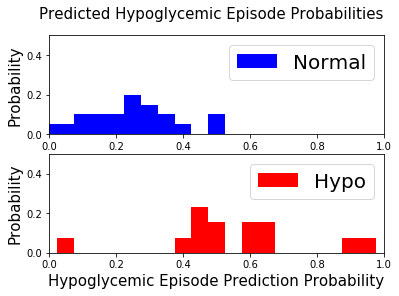

In [72]:
################################################# Prediction & Performance ################################################# 
def prediction(x_test, y_test, y_pred, prob, model):
  cm_true_pred = confusion_matrix(y_test, y_pred, labels = [0, 1])
  ncm_true_pred = cm_true_pred.astype('float') / cm_true_pred.sum(axis=1)[:, np.newaxis]
# Normalize the confusion matrix by row (i.e by the number of samples in each class)

  print("correct predictions (0 in 0 & 1 in 1):", np.round((cm_true_pred[0][0]+cm_true_pred[1][1])*100.0/np.sum(cm_true_pred), 2))
  print("mean probabilities = for 0:", np.round(np.mean(prob[:,0]), 2), '& for 1:', np.round(np.mean(prob[:,1]), 2))
  print("Confusion Matrix true_pred:\n", cm_true_pred)
  plot_confusion_matrix(ncm_true_pred, 'True Label', 'Predicted Label')
  plt.savefig('ncm.png')

  print("oob_score", np.round(model.oob_score_, 2))
  print("recall_score", np.round(recall_score(y_test, y_pred, average='binary'), 2))


# plot 1D histogram of 1ursor probabilities in '0' and '1' regions:
  prob_0 = prob[y_test == 0, 1]
  prob_1 = prob[y_test == 1, 1]
  plot_hist(prob_0, prob_1)
  plt.savefig('hypo_prob.png')

prediction(x_test, y_test, y_pred, prob, model)

Feature ranking:
1. feature 9 (0.262609)
2. feature 7 (0.245497)
3. feature 2 (0.088752)
4. feature 6 (0.074871)
5. feature 1 (0.073792)
6. feature 4 (0.073733)
7. feature 11 (0.055147)
8. feature 10 (0.050509)
9. feature 8 (0.039519)
10. feature 5 (0.027689)
11. feature 3 (0.005292)
12. feature 0 (0.002589)


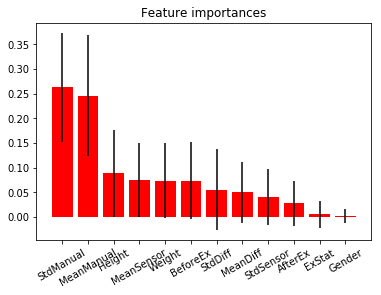

In [24]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), features[indices],rotation=30)
plt.xlim([-1, x_train.shape[1]])
plt.show()


In [28]:
rf = RandomForestClassifier()
lr = LogisticRegression()

scores = cross_val_score(rf, x_train, y_train.ravel(), cv=5)
print(scores.mean()*100)
print(scores.std()*100)
print(scores)	

scores = cross_val_score(lr, x_train, y_train.ravel(), cv=5)
print(scores.mean()*100)
print(scores.std()*100)
print(scores)

71.6967418546
8.49265270499
[ 0.61904762  0.65        0.78947368  0.84210526  0.68421053]
75.3959899749
10.8682256327
[ 0.76190476  0.85        0.89473684  0.63157895  0.63157895]
